## Import Library

In [87]:
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as F
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()

True

## Setup Sparkstandalone Session

In [2]:
spark = SparkSession \
    .builder \
    .master('spark://localhost:7077') \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.1") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.type", "SERVICE_ACCOUNT_JSON_KEYFILE") \
    .config("spark.hadoop.fs.gs.project.id", os.getenv('PROJECT_ID')) \
    .appName("fisiology_spark") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/Bagas/spark/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/Bagas/.ivy2/cache
The jars for the packages stored in: /home/Bagas/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-68cb7779-06db-46cd-8bb7-2034b6a16242;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 in central
:: resolution report :: resolve 137ms :: artifacts dl 4ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-------------------------------------------------------------------

## Connection to GCS Test

In [ ]:
base_path = 'gs://project-abd/raw/class_wearable_data/'

def sample_wearable(class_id, participant_id):
    session_path = os.path.join(base_path, str(class_id), str(participant_id))
    print(f'Processing : {session_path}..')
    
    sensor_map = {}
    sensors = {'HR.csv': 'HR', 'TEMP.csv': 'TEMP'}
    
    for file_name, sensor_prefix in sensors.items():
        file_path = os.path.join(session_path, file_name)
        try:
            df_sensor = pd.read_csv(file_path, header=None, names=[sensor_prefix, 'Time'])
            
            df_sensor.dropna(subset=['Time'], inplace=True)
            df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')
            df_sensor[sensor_prefix] = pd.to_numeric(df_sensor[sensor_prefix], errors='coerce')
            df_sensor.dropna(subset=[sensor_prefix], inplace=True)
            
            if not df_sensor.empty:
                df_sensor.set_index('Time', inplace=True)
                sensor_map[sensor_prefix] = df_sensor[[sensor_prefix]]

        except FileNotFoundError:
            print(f'File not found: {file_path}')
        except Exception as e:
            print(f'Error processing {file_path}: {e}')
    
    if not sensor_map:
        return pd.DataFrame()
    
    all_features = []
    for sensor_prefix, sensor_df in sensor_map.items():
        if not sensor_df.empty and not sensor_df.isnull().all().all():
            features = sensor_df.resample('5min').mean().reset_index()
            features.columns = ['time', f'{sensor_prefix}_mean']
            all_features.append(features.set_index('time'))

    if not all_features:
        return pd.DataFrame()

    final_features_pd = pd.concat(all_features, axis=1).reset_index()
    final_features_pd['time'] =   final_features_pd['time'].dt.strftime('%H:%M:%S')
    final_features_pd['participant_id'] = participant_id
    final_features_pd['class_id'] = class_id

    return final_features_pd

In [29]:
test = sample_wearable(1, 1)
test.head()

Processing : gs://project-abd/raw/class_wearable_data/1/1..


/tmp/ipykernel_25290/1930031351.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')
/tmp/ipykernel_25290/1930031351.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')


,time,HR_mean,TEMP_mean,participant_id,class_id
0,09:20:00,101.968507,18.796667,1,1
1,09:25:00,112.202900,18.799200,1,1
2,09:30:00,110.074467,18.782200,1,1
3,09:35:00,124.705167,18.653233,1,1


## Load Data (Sample)

In [ ]:
base_path = 'gs://project-abd/raw/class_wearable_data/'

schema = types.StructType([
    types.StructField('value', types.FloatType(), True),
    types.StructField('Time', types.TimestampType(), True)
])

hr = spark.read.schema(schema).csv(base_path + '/1/*/HR.csv')
temp = spark.read.schema(schema).csv(base_path + '/1/*/TEMP.csv')
eda = spark.read.schema(schema).csv(base_path + '/1/*/EDA.csv')
ibi = spark.read.schema(schema).csv(base_path + '/1/*/IBI.csv')
bvp = spark.read.schema(schema).csv(base_path + '/1/*/BVP.csv')

## Preprocess Data

In [57]:
def extract_id(df):
    df = df.withColumn('class_id', F.regexp_extract(F.input_file_name(),r'class_wearable_data/(\d+)/',1).cast('int'))
    df = df.withColumn('participant_id', F.regexp_extract(F.input_file_name(),r'class_wearable_data/\d+/(\d+)/',1).cast('int'))
    return df

In [58]:
hr = extract_id(hr)
temp = extract_id(temp)
eda = extract_id(eda)
ibi = extract_id(ibi)
bvp = extract_id(bvp)

In [59]:
hr.show(5)

+-----+-------------------+--------+--------------+
|value|               Time|class_id|participant_id|
+-----+-------------------+--------+--------------+
| NULL|               NULL|       1|            13|
| 52.0|2025-06-01 09:22:39|       1|            13|
| 52.0|2025-06-01 09:22:40|       1|            13|
|53.33|2025-06-01 09:22:41|       1|            13|
| 60.0|2025-06-01 09:22:42|       1|            13|
+-----+-------------------+--------+--------------+
only showing top 5 rows



In [60]:
def format_time(df):
    return df.withColumn('time_format',
                         F.date_format('Time','HH:mm:ss')).drop('Time')

hr_time = format_time(hr)
temp_time = format_time(temp)
eda_time = format_time(eda)
ibi_time = format_time(ibi)
bvp_time = format_time(bvp)

In [62]:
hr_time.show(5)

+-----+--------+--------------+-----------+
|value|class_id|participant_id|time_format|
+-----+--------+--------------+-----------+
| NULL|       1|            13|       NULL|
| 52.0|       1|            13|   09:22:39|
| 52.0|       1|            13|   09:22:40|
|53.33|       1|            13|   09:22:41|
| 60.0|       1|            13|   09:22:42|
+-----+--------+--------------+-----------+
only showing top 5 rows



In [64]:
def agg_sensor(df, alias):
    return df.groupby('class_id', 'participant_id', F.window('time_format','5 minutes')
                    ).agg(F.mean('value').alias(alias))

hr_agg = agg_sensor(hr_time, 'hr_mean')
temp_agg = agg_sensor(temp_time, 'temp_mean')
eda_agg = agg_sensor(eda_time, 'eda_mean')
ibi_agg = agg_sensor(ibi_time, 'ibi_mean')
bvp_agg = agg_sensor(bvp_time, 'bvp_mean')

In [68]:
df_to_join = [hr_agg, temp_agg, eda_agg, ibi_agg, bvp_agg]
df_join = reduce(lambda left,right:
    left.join(right, on=
              ['class_id',
               'participant_id',
               'window'], how='outer'),
    df_to_join)

In [113]:
final_df = df_join.withColumn('time', F.col('window').start).withColumn('time_format', F.date_format('time', 'HH:mm:ss')) \
    .select('class_id', 'participant_id', 'time_format','hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean'
).orderBy('class_id', 'participant_id', 'time')

final_df.show(5)

+--------+--------------+-----------+------------------+------------------+--------------------+-------------------+--------------------+
|class_id|participant_id|time_format|           hr_mean|         temp_mean|            eda_mean|           ibi_mean|            bvp_mean|
+--------+--------------+-----------+------------------+------------------+--------------------+-------------------+--------------------+
|       1|             1|   09:20:00|101.96850751051262| 18.79666699303521|0.001454626731881...|0.46877134839693707|0.005812729376985872|
|       1|             1|   09:25:00|112.20290006001791| 18.79920024236043|3.533424931811168...|0.38022567331790924| 0.01111510058719432|
|       1|             1|   09:30:00|110.07446683247885|18.782200450897218|3.661524929339066E-4| 0.3854343295097351|-0.01442968695181...|
|       1|             1|   09:35:00| 124.7051665242513| 18.65323377609253|2.006899961270392E-4|0.38790275516668205|6.333332597084033E-4|
|       1|             2|   09:20:

In [116]:
final_df.coalesce(1).write.option("header", True).mode('overwrite').csv("/home/Bagas/project/dataset/fisiology_output")

## EDA 

In [73]:
final_df.describe(['hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean']).show()

25/06/01 15:30:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+--------------------+-------------------+--------------------+
|summary|           hr_mean|         temp_mean|            eda_mean|           ibi_mean|            bvp_mean|
+-------+------------------+------------------+--------------------+-------------------+--------------------+
|  count|                88|                88|                  88|                 85|                  88|
|   mean|120.17367245653077|19.112059755548245|0.003787398412975...| 0.4701122691957643|0.002871968805713...|
| stddev| 18.63071445152118|0.3821711350907827|0.006773826399398207|0.06708573731285124| 0.02964958115521278|
|    min| 90.62831892165462| 18.17183364868164|                 0.0| 0.3593914955854416| -0.0933947939867115|
|    max|177.77219985961915|20.987748480790497| 0.02104522231966257| 0.6180616888650663| 0.09704513356102527|
+-------+------------------+------------------+--------------------+-------------------+--------------------+



In [85]:
df_pd = final_df.toPandas()

def tren_line(id,data) :
    sns.lineplot(data=df_pd[df_pd['participant_id'] == {id}], x = df_pd['time_format'], y = df_pd[f'{data}']) 
    plt.title(f'Tren Line for {data} for participant {id}')
    plt.show()

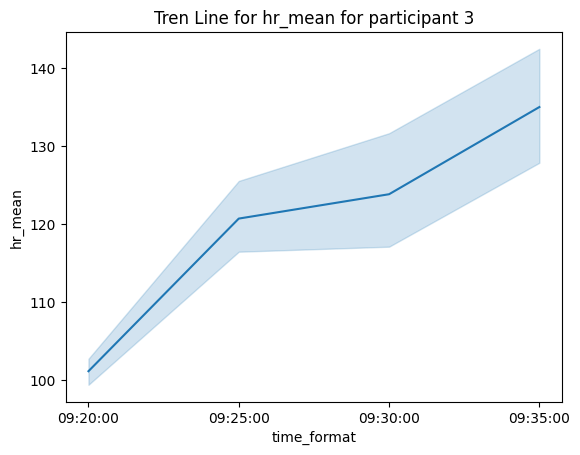

In [88]:
tren_line(3, 'hr_mean')

In [84]:
df_pd[['hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean']].corr()

,hr_mean,temp_mean,eda_mean,ibi_mean,bvp_mean
hr_mean,1.000000,-0.167172,-0.127973,-0.334329,-0.095620
temp_mean,-0.167172,1.000000,0.248986,0.035972,0.099526
eda_mean,-0.127973,0.248986,1.000000,0.029342,0.051066
ibi_mean,-0.334329,0.035972,0.029342,1.000000,0.030214
bvp_mean,-0.095620,0.099526,0.051066,0.030214,1.000000


In [104]:
if not os.path.exists('/home/Bagas/project/dataset/fisiology'):
    os.makedirs('/home/Bagas/project/dataset/fisiology')
    
final_df.write \
            .mode('overwrite') \
            .option('header', True) \
            .csv('/home/Bagas/project/dataset/fisiology')

In [117]:
df_pd.to_csv('/home/Bagas/project/dataset/fisiology.csv')